## Compressing one-hot encodings - MLP

Want to experiment with adding them to the GCN. In the other notebook we tried to do this using an autoencoder. Here we try and do it with an MLP, with the penultimate layer being length 64.

In [1]:
import sys
sys.path.insert(0, "..")
import TCGAData, numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import seaborn as sns
import tqdm
import copy
import torch
import torch.nn as nn
import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
root = "/mnt/home/sgolkar/projects/cancer-net/data/brain"
files = "/mnt/home/sgolkar/projects/cancer-net/data/brain/samples.txt"
label_mapping = ["LGG", "GBM"]
dataset = TCGAData.TCGADataset(
    root=root,
    files=files,
    label_mapping=label_mapping,
    gene_graph="brain.geneSymbol.gz",test_ratio=0,
)

In [3]:
gene_dict = {
    el: i
    for i, el in enumerate(
        set([item for sublist in dataset.data.node_id for item in sublist])
    )
}
num_genes = len(gene_dict)

Xmutated = np.zeros((dataset.num_samples, num_genes))
Xmutnorm = np.zeros((dataset.num_samples, num_genes))


for sample_num in range(dataset.num_samples):
    sample_data = dataset.get(sample_num)
    for encoding, sample_gene in zip(sample_data.x, sample_data.node_id):
        Xmutated[sample_num, gene_dict[sample_gene]] = 1
        Xmutnorm[sample_num, gene_dict[sample_gene]] = np.linalg.norm(encoding)

Xmutatedv2 = (Xmutnorm != 0).astype(float)

In [35]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        self.layers = nn.Sequential(
            nn.Linear(int(num_genes),  512),
            nn.ReLU(),
            nn.Linear(512,  64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
  
    def forward(self, x):
        return self.layers(x)

In [36]:
# Model Initialization
model = MLP()
model.float()
  
# Validation using MSE Loss function
criterion = F.nll_loss
loss_function = torch.nn.MSELoss()
  
# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 5e-5,
                             weight_decay = 1e-2)

In [37]:
## Set data
valid_seed=0

dataset.set_valid_seed(valid_seed)

x_train = Xmutated[dataset.train_idx]
x_valid = Xmutated[dataset.valid_idx]

y_train = dataset.data.y[dataset.train_idx]
y_valid = dataset.data.y[dataset.valid_idx]
len(Xmutated[0])

15146

In [38]:
type(y_train)

torch.Tensor

In [39]:
class MutDataset(Dataset):
    """ One-hot encoding of mutations dataset """

    def __init__(self, Xmutated,y):
        self.Xmutated=torch.from_numpy(Xmutated).float()
        self.y=y

    def __len__(self):
        return len(self.Xmutated)

    def __getitem__(self, idx):
        return self.Xmutated[idx],self.y[idx]

In [40]:
train_loader=DataLoader(MutDataset(x_train,y_train),batch_size=10)
valid_loader=DataLoader(MutDataset(x_valid,y_valid),batch_size=10)

In [41]:
epochs = 250
total_loss = 0
correct = 0
num_samps = 0
outputs = []
train_loss = []
validation_loss = []
for epoch in range(epochs):
    print("epoch:",epoch)
    t_loss=[]
    v_loss=[]
    for x,y in train_loader:
        optimizer.zero_grad()

        output = model(x)
        output = output.squeeze()

        loss = torch.mean((output - y)**2,                axis=0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        t_loss.append(loss.item())
    
    for x,y in valid_loader:
        optimizer.zero_grad()

        output = model(x)
        output = output.squeeze()

        valid_loss = torch.mean((output - y)**2,                axis=0)

        # Storing the losses in a list for plotting
        v_loss.append(valid_loss.item())
    loss_epoch=np.mean(np.array(t_loss))
    vloss_epoch=np.mean(np.array(v_loss))
    print("Training loss:",loss_epoch)
    train_loss.append(loss_epoch)
    print("Valid loss:",vloss_epoch)
    validation_loss.append(vloss_epoch)
    #outputs.append((epochs, image, reconstructed))

epoch: 0
Training loss: 0.3961252416484058
Valid loss: 0.2892349927375714
epoch: 1
Training loss: 0.31944703054614365
Valid loss: 0.2589069923075537
epoch: 2
Training loss: 0.24420441675465554
Valid loss: 0.22892786065737405
epoch: 3
Training loss: 0.17008270497899503
Valid loss: 0.2057289476506412
epoch: 4
Training loss: 0.10761598756653257
Valid loss: 0.18898290457824865
epoch: 5
Training loss: 0.1347640110179782
Valid loss: 0.16448747972026467
epoch: 6
Training loss: 0.05494609789457172
Valid loss: 0.18182463121290007
epoch: 7
Training loss: 0.05904920144530479
Valid loss: 0.14869745215401053
epoch: 8
Training loss: 0.038940817656111903
Valid loss: 0.15297215897589922
epoch: 9
Training loss: 0.02535328072917764
Valid loss: 0.15057557712619504
epoch: 10
Training loss: 0.019842639407215756
Valid loss: 0.14735785126686096
epoch: 11
Training loss: 0.017810481654123578
Valid loss: 0.14477275389557084
epoch: 12
Training loss: 0.017341425107588293
Valid loss: 0.1466138882872959
epoch: 13
T

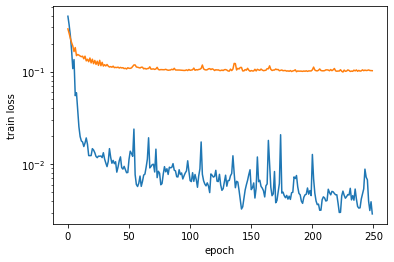

In [42]:
plt.plot(range(epochs),train_loss)
plt.plot(range(epochs),validation_loss)
plt.ylabel("train loss")
plt.xlabel("epoch")
plt.yscale("log")

In [53]:
y_pred=np.array([])
y_true=np.array([])
for x,y in valid_loader:
    out=model(x)
    y_pred=np.append(out.cpu().detach().numpy(),y_pred)
    y_true=np.append(y_true,y.cpu().detach().numpy())

In [63]:
y_pred=np.array([])
y_true=np.array([])
for x,y in train_loader:
    out=model(x)
    y_pred=np.append(out.cpu().detach().numpy(),y_pred)
    y_true=np.append(y_true,y.cpu().detach().numpy())

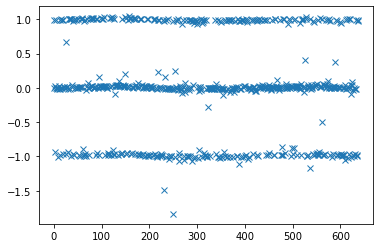

In [64]:
plt.plot(range(len(y_pred)),y_true-y_pred,"x")

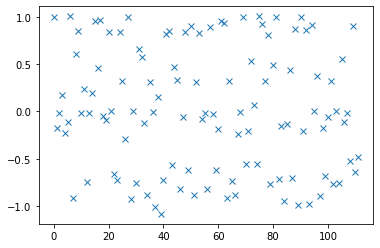

In [62]:
plt.plot(range(len(y_pred)),y_true-y_pred,"x")

In [57]:
y_pred.shape

(112,)

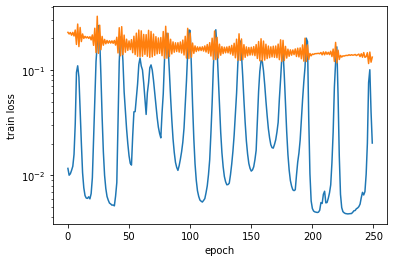

In [34]:
plt.plot(range(epochs),train_loss)
plt.plot(range(epochs),validation_loss)
plt.ylabel("train loss")
plt.xlabel("epoch")
plt.yscale("log")

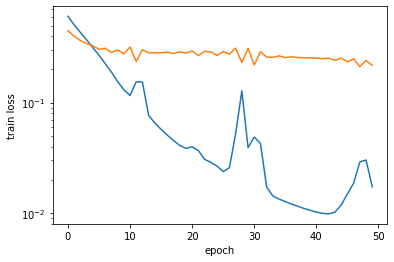

In [32]:
plt.plot(range(epochs),train_loss)
plt.plot(range(epochs),validation_loss)
plt.ylabel("train loss")
plt.xlabel("epoch")
plt.yscale("log")

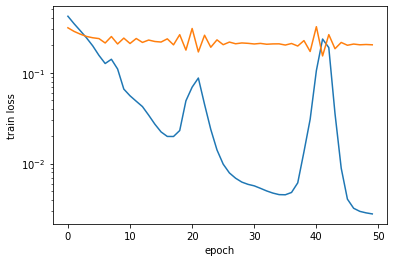

In [24]:
plt.plot(range(epochs),train_loss)
plt.plot(range(epochs),validation_loss)
plt.ylabel("train loss")
plt.xlabel("epoch")
plt.yscale("log")

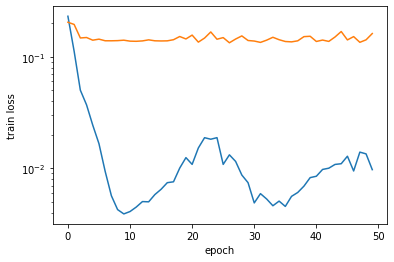

In [16]:
plt.plot(range(epochs),train_loss)
plt.plot(range(epochs),validation_loss)
plt.ylabel("train loss")
plt.xlabel("epoch")
plt.yscale("log")

In [25]:
sum(p.numel() for p in model.parameters())

969473

In [ ]:
plt.plot(pred[0].detach().numpy())

In [ ]:
plt.plot(x[0].detach().numpy())

In [ ]:
plt.plot(x[0].detach().numpy()-pred[0].detach().numpy())

In [ ]:
plt.plot(x[1].detach().numpy()-pred[1].detach().numpy())

In [ ]:
    for data in valid_loader:
        if not parall:
            data = data.to(device)
        output = model(data)
        output = output.squeeze()

        pred = output.max(1)[1]
        if parall:
            y = torch.cat([d.y for d in data]).to(output.device)
        else:
            y = data.y
        loss = criterion(output, y)
        total_loss += loss.item()

        correct += pred.eq(y).sum().item()
        num_samps += len(y)

In [ ]:
total_loss=0

In [ ]:
for (valid, _) in valid_loader:
    pred = model(valid)
    pred = pred.squeeze()
    valid_loss = loss_function(pred, valid)
    total_loss += valid_loss.item()
    valid_loss = total_loss/len(pred)

In [ ]:
len(pred)

In [ ]:
valid_loss.item()

In [ ]:
x_valid.shape

In [ ]:
x_train.shape

In [ ]:
638+112

In [ ]:
len(Xmutated)

In [ ]:
len(gene_dict)

In [ ]:
Xmutnorm[0][47]